In [1]:
from gurobipy import Model, GRB, quicksum

# Initialize the model
model = Model("VRPSPD")

# Define sets
nodes = [0, 1, 2, 3, 4]  # 0 is the depot
customer_nodes = [1, 2, 3, 4]  # Excluding depot
vehicles = [0, 1]  # Two vehicles
K = len(vehicles)  # Total number of vehicles

# Example data
distance = {(i, j): 10 for i in nodes for j in nodes if i != j}  # Dummy distances
capacity = 100  # Vehicle capacity Q
pickup = {1: 10, 2: 15, 3: 20, 4: 25}
delivery = {1: 5, 2: 10, 3: 15, 4: 20}
M1 = 1000  # Big-M constant for delivery
M2 = 1000  # Big-M constant for load

# Decision Variables
x = model.addVars(nodes, nodes, vtype=GRB.BINARY, name="x")
D = model.addVars(nodes, vtype=GRB.CONTINUOUS, name="D")  # Delivery load
L = model.addVars(nodes, vtype=GRB.CONTINUOUS, name="L")  # Total load

# Prevent self-loops
for i in nodes:
    model.addConstr(x[i, i] == 0, name=f"no_self_loop_{i}")

# **Constraint 1: Each customer node is left by exactly one vehicle**
for j in customer_nodes:
    model.addConstr(quicksum(x[i, j] for i in nodes if i != j) == 1, name=f"leave_once_{j}")

# **Constraint 2: Each customer node is approached by exactly one vehicle**
for j in customer_nodes:
    model.addConstr(quicksum(x[j, i] for i in nodes if i != j) == 1, name=f"approach_once_{j}")

# **Constraint 3: At most `K` vehicles leave the depot**
model.addConstr(quicksum(x[0, i] for i in customer_nodes) <= K, name="limit_vehicles_leaving_depot")

# **Constraint 4: Delivery load consistency**
for i in customer_nodes:
    for j in customer_nodes:
        model.addConstr(D[i] >= D[j] + delivery[i] - M1 * (1 - x[i, j]), name=f"delivery_consistency_{i}_{j}")

# **Constraint 5: Load consistency at customer nodes**
for j in customer_nodes:
    model.addConstr(L[j] >= D[j] - delivery[j] + pickup[j], name=f"load_consistency_{j}")

# **Constraint 6: Load consistency between nodes**
for i in customer_nodes:
    for j in customer_nodes:
        model.addConstr(L[j] >= L[i] - delivery[j] + pickup[j] - M2 * (1 - x[i, j]), name=f"load_transfer_{i}_{j}")

# **Constraint 7: Delivery demand feasibility**
for i in customer_nodes:  # CHANGED: Iterate over customer_nodes instead of nodes
    model.addConstr(delivery[i] <= D[i], name=f"delivery_feasibility_lower_{i}")
    model.addConstr(D[i] <= capacity, name=f"delivery_feasibility_upper_{i}")

# **Constraint 8: Pickup demand feasibility**
for i in customer_nodes:  # CHANGED: Iterate over customer_nodes instead of nodes
    model.addConstr(pickup[i] <= L[i], name=f"pickup_feasibility_lower_{i}")
    model.addConstr(L[i] <= capacity, name=f"pickup_feasibility_upper_{i}")

# **Constraint 9: Binary constraint for vehicle routing**
for i in nodes:
    for j in nodes:
        model.addConstr(x[i, j] >= 0, name=f"binary_lb_{i}_{j}")
        model.addConstr(x[i, j] <= 1, name=f"binary_ub_{i}_{j}")

# **Constraint 10: Non-negativity of load variables**
for i in nodes:
    model.addConstr(D[i] >= 0, name=f"non_negative_D_{i}")
    model.addConstr(L[i] >= 0, name=f"non_negative_L_{i}")

# Objective: Minimize total distance traveled
model.setObjective(quicksum(distance[i, j] * x[i, j] for i in nodes for j in nodes if i != j), GRB.MINIMIZE)

# Solve Model
model.optimize()

Restricted license - for non-production use only - expires 2026-11-23
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 7735HS with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 126 rows, 35 columns and 205 nonzeros
Model fingerprint: 0x1eb61a73
Variable types: 10 continuous, 25 integer (25 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+01, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Found heuristic solution: objective 60.0000000
Presolve removed 89 rows and 11 columns
Presolve time: 0.01s
Presolved: 37 rows, 24 columns, 160 nonzeros
Variable types: 8 continuous, 16 integer (16 binary)

Root relaxation: objective 4.000000e+01, 19 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl

In [2]:
if model.status == GRB.OPTIMAL:
    print("\nOptimal Solution Found:")
    for var in model.getVars():
        print(f"{var.varName}: {var.x}")
    print(f"\nObjective Value: {model.objVal}")



Optimal Solution Found:
x[0,0]: 0.0
x[0,1]: 0.0
x[0,2]: 0.0
x[0,3]: 0.0
x[0,4]: 1.0
x[1,0]: 0.0
x[1,1]: 0.0
x[1,2]: 1.0
x[1,3]: 0.0
x[1,4]: 0.0
x[2,0]: 0.0
x[2,1]: 0.0
x[2,2]: 0.0
x[2,3]: 1.0
x[2,4]: 0.0
x[3,0]: 1.0
x[3,1]: 0.0
x[3,2]: 0.0
x[3,3]: 0.0
x[3,4]: 0.0
x[4,0]: 0.0
x[4,1]: 1.0
x[4,2]: 0.0
x[4,3]: 0.0
x[4,4]: 0.0
D[0]: 0.0
D[1]: 30.0
D[2]: 25.0
D[3]: 15.0
D[4]: 50.0
L[0]: 0.0
L[1]: 60.0
L[2]: 65.0
L[3]: 70.0
L[4]: 55.0

Objective Value: 50.0


In [4]:
from gurobipy import Model, GRB, quicksum

def verify_vrpspd():
    # Initialize the model
    model = Model("VRPSPD_Verification")

    # Define sets
    nodes = [0, 1, 2, 3, 4]  # 0 is the depot
    customer_nodes = [1, 2, 3, 4]
    vehicles = [0, 1]  # Two vehicles

    # Example data
    distance = {(i, j): 10 for i in nodes for j in nodes if i != j}
    capacity = 100  # Vehicle capacity
    pickup = {1: 10, 2: 15, 3: 20, 4: 25}
    delivery = {1: 5, 2: 10, 3: 15, 4: 20}
    M1, M2 = 1000, 1000  # Big-M constants

    # Decision Variables
    x = model.addVars(nodes, nodes, vtype=GRB.BINARY, name="x")
    D = model.addVars(nodes, vtype=GRB.CONTINUOUS, name="D")  # Delivery load
    L = model.addVars(nodes, vtype=GRB.CONTINUOUS, name="L")  # Total load

    # Constraints
    for i in nodes:
        model.addConstr(x[i, i] == 0, name=f"no_self_loop_{i}")

    for j in customer_nodes:
        model.addConstr(quicksum(x[i, j] for i in nodes if i != j) == 1, name=f"leave_once_{j}")
        model.addConstr(quicksum(x[j, i] for i in nodes if i != j) == 1, name=f"approach_once_{j}")

    model.addConstr(quicksum(x[0, i] for i in customer_nodes) <= len(vehicles), name="limit_vehicles_leaving_depot")

    for i in customer_nodes:
        for j in customer_nodes:
            model.addConstr(D[i] >= D[j] + delivery[i] - M1 * (1 - x[i, j]), name=f"delivery_consistency_{i}_{j}")
            model.addConstr(L[j] >= L[i] - delivery[j] + pickup[j] - M2 * (1 - x[i, j]), name=f"load_transfer_{i}_{j}")

    for i in customer_nodes:
        model.addConstr(delivery[i] <= D[i], name=f"delivery_feasibility_lower_{i}")
        model.addConstr(D[i] <= capacity, name=f"delivery_feasibility_upper_{i}")
        model.addConstr(pickup[i] <= L[i], name=f"pickup_feasibility_lower_{i}")
        model.addConstr(L[i] <= capacity, name=f"pickup_feasibility_upper_{i}")

    # Objective: Minimize total distance traveled
    model.setObjective(quicksum(distance[i, j] * x[i, j] for i in nodes for j in nodes if i != j), GRB.MINIMIZE)

    # Solve the model
    model.optimize()

    # Verification
    constraint_violations = []

    if model.status != GRB.OPTIMAL:
        print("Model did not find an optimal solution.")
        return

    # Prevent self-loops
    for i in nodes:
        if x[i, i].X != 0:
            constraint_violations.append(f"Self-loop constraint violated at node {i}")

    # Each customer node is left and approached exactly once
    for j in customer_nodes:
        if abs(sum(x[i, j].X for i in nodes if i != j) - 1) > 1e-6:
            constraint_violations.append(f"Customer {j} not left exactly once")
        if abs(sum(x[j, i].X for i in nodes if i != j) - 1) > 1e-6:
            constraint_violations.append(f"Customer {j} not approached exactly once")

    # Vehicle constraints
    if sum(x[0, i].X for i in customer_nodes) > len(vehicles):
        constraint_violations.append("Too many vehicles leaving the depot")

    # Load consistency checks
    for i in customer_nodes:
        for j in customer_nodes:
            if D[i].X < D[j].X + delivery[i] - M1 * (1 - x[i, j].X):
                constraint_violations.append(f"Delivery load consistency violated between {i} and {j}")
            if L[j].X < L[i].X - delivery[j] + pickup[j] - M2 * (1 - x[i, j].X):
                constraint_violations.append(f"Load transfer consistency violated between {i} and {j}")

    # Delivery and pickup feasibility
    for i in customer_nodes:
        if delivery[i] > D[i].X or D[i].X > capacity:
            constraint_violations.append(f"Delivery demand feasibility violated at node {i}")
        if pickup[i] > L[i].X or L[i].X > capacity:
            constraint_violations.append(f"Pickup demand feasibility violated at node {i}")

    # Display verification results
    if constraint_violations:
        print("Verification Failed: Constraint Violations Found")
        for violation in constraint_violations:
            print(violation)
    else:
        print("Verification Passed: No Constraint Violations")

# Run verification
verify_vrpspd()


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 7735HS with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 62 rows, 35 columns and 137 nonzeros
Model fingerprint: 0xac3df572
Variable types: 10 continuous, 25 integer (25 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+01, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Found heuristic solution: objective 60.0000000
Presolve removed 29 rows and 11 columns
Presolve time: 0.00s
Presolved: 33 rows, 24 columns, 152 nonzeros
Variable types: 8 continuous, 16 integer (16 binary)

Root relaxation: objective 4.000000e+01, 12 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 7735HS with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 62 rows, 35 columns and 137 nonzeros
Model fingerprint: 0x174f9387
Variable types: 10 continuous, 25 integer (25 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+01, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Found heuristic solution: objective 60.0000000
Presolve removed 29 rows and 11 columns
Presolve time: 0.00s
Presolved: 33 rows, 24 columns, 152 nonzeros
Variable types: 8 continuous, 16 integer (16 binary)

Root relaxation: objective 4.000000e+01, 14 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     

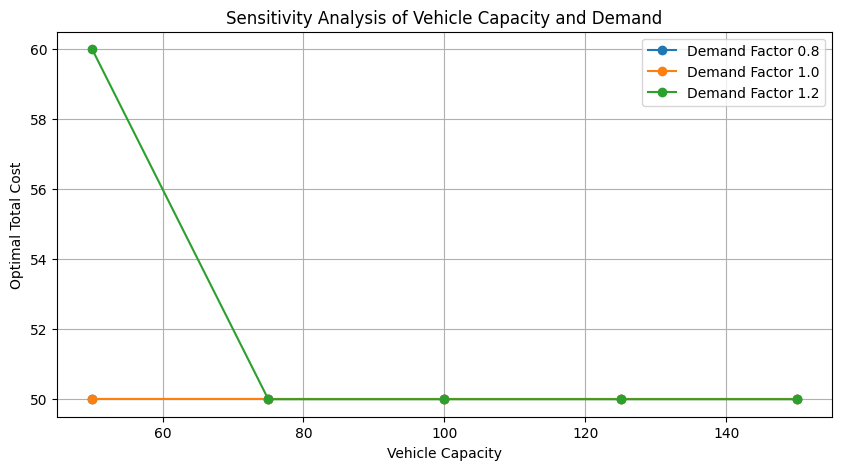

In [6]:
import gurobipy as gp
from gurobipy import GRB, quicksum
import pandas as pd
import matplotlib.pyplot as plt

def run_sensitivity_analysis():
    # Define sets
    nodes = [0, 1, 2, 3, 4]  # 0 is the depot
    customer_nodes = [1, 2, 3, 4]
    vehicles = [0, 1]  # Two vehicles

    # Base Case Data
    base_capacity = 100  # Vehicle capacity
    base_pickup = {1: 10, 2: 15, 3: 20, 4: 25}
    base_delivery = {1: 5, 2: 10, 3: 15, 4: 20}
    distance = {(i, j): 10 for i in nodes for j in nodes if i != j}
    
    # Test Scenarios
    capacities = [50, 75, 100, 125, 150]  # Sensitivity on capacity
    demand_factors = [0.8, 1.0, 1.2]  # Sensitivity on pickup & delivery (80%, 100%, 120%)
    
    results = []

    for capacity in capacities:
        for factor in demand_factors:
            # Adjust demand
            pickup = {k: int(base_pickup[k] * factor) for k in base_pickup}
            delivery = {k: int(base_delivery[k] * factor) for k in base_delivery}

            # Initialize the model
            model = gp.Model("VRPSPD_Sensitivity")

            # Decision Variables
            x = model.addVars(nodes, nodes, vtype=GRB.BINARY, name="x")
            D = model.addVars(nodes, vtype=GRB.CONTINUOUS, name="D")
            L = model.addVars(nodes, vtype=GRB.CONTINUOUS, name="L")

            # Constraints
            for i in nodes:
                model.addConstr(x[i, i] == 0, name=f"no_self_loop_{i}")

            for j in customer_nodes:
                model.addConstr(quicksum(x[i, j] for i in nodes if i != j) == 1, name=f"leave_once_{j}")
                model.addConstr(quicksum(x[j, i] for i in nodes if i != j) == 1, name=f"approach_once_{j}")

            model.addConstr(quicksum(x[0, i] for i in customer_nodes) <= len(vehicles), name="limit_vehicles")

            for i in customer_nodes:
                for j in customer_nodes:
                    model.addConstr(D[i] >= D[j] + delivery[i] - 1000 * (1 - x[i, j]), name=f"delivery_consistency_{i}_{j}")
                    model.addConstr(L[j] >= L[i] - delivery[j] + pickup[j] - 1000 * (1 - x[i, j]), name=f"load_transfer_{i}_{j}")

            for i in customer_nodes:
                model.addConstr(delivery[i] <= D[i], name=f"delivery_feasibility_{i}")
                model.addConstr(D[i] <= capacity, name=f"capacity_limit_D_{i}")
                model.addConstr(pickup[i] <= L[i], name=f"pickup_feasibility_{i}")
                model.addConstr(L[i] <= capacity, name=f"capacity_limit_L_{i}")

            # Objective: Minimize total distance
            model.setObjective(quicksum(distance[i, j] * x[i, j] for i in nodes for j in nodes if i != j), GRB.MINIMIZE)

            # Solve Model
            model.optimize()

            # Store Results
            if model.status == GRB.OPTIMAL:
                results.append({
                    "Capacity": capacity,
                    "Demand Factor": factor,
                    "Optimal Cost": model.objVal
                })

    # Convert results to DataFrame
    df_results = pd.DataFrame(results)

    print(df_results)


    # Plot Results
    plt.figure(figsize=(10, 5))
    for factor in demand_factors:
        subset = df_results[df_results["Demand Factor"] == factor]
        plt.plot(subset["Capacity"], subset["Optimal Cost"], marker='o', label=f"Demand Factor {factor}")

    plt.xlabel("Vehicle Capacity")
    plt.ylabel("Optimal Total Cost")
    plt.title("Sensitivity Analysis of Vehicle Capacity and Demand")
    plt.legend()
    plt.grid(True)
    plt.show()

# Run the sensitivity analysis
run_sensitivity_analysis()


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 7735HS with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 62 rows, 35 columns and 137 nonzeros
Model fingerprint: 0x7c04c2f3
Variable types: 10 continuous, 25 integer (25 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+01, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Found heuristic solution: objective 50.0000000
Presolve removed 29 rows and 11 columns
Presolve time: 0.00s
Presolved: 33 rows, 24 columns, 152 nonzeros
Variable types: 8 continuous, 16 integer (16 binary)

Root relaxation: objective 4.000000e+01, 14 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     

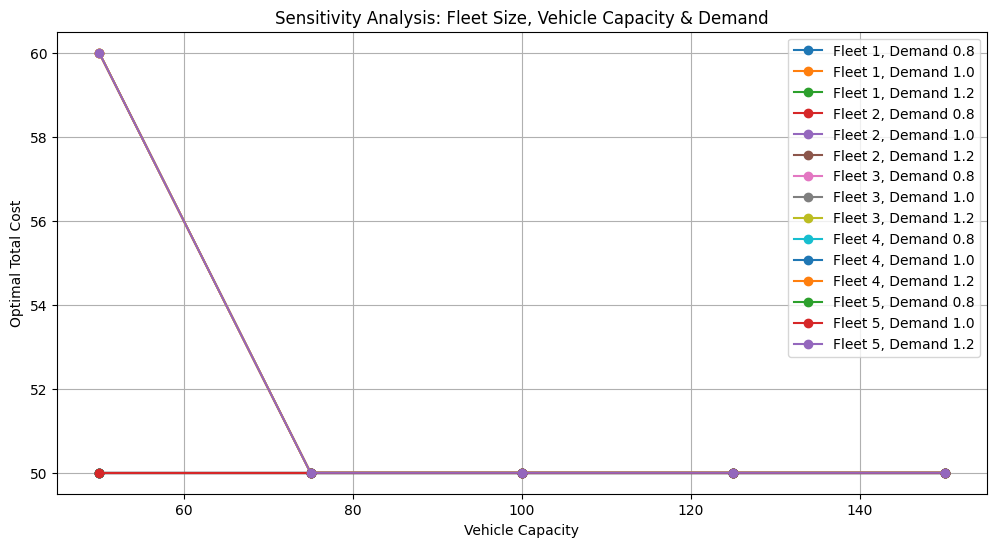

In [7]:
import gurobipy as gp
from gurobipy import GRB, quicksum
import pandas as pd
import matplotlib.pyplot as plt

def extended_sensitivity_analysis():
    # Define sets
    nodes = [0, 1, 2, 3, 4]  # 0 is the depot
    customer_nodes = [1, 2, 3, 4]

    # Base Case Data
    base_capacity = 100  # Vehicle capacity
    base_pickup = {1: 10, 2: 15, 3: 20, 4: 25}
    base_delivery = {1: 5, 2: 10, 3: 15, 4: 20}
    distance = {(i, j): 10 for i in nodes for j in nodes if i != j}
    
    # Test Scenarios
    capacities = [50, 75, 100, 125, 150]  # Sensitivity on capacity
    demand_factors = [0.8, 1.0, 1.2]  # Sensitivity on demand
    fleet_sizes = [1, 2, 3, 4, 5]  # Number of vehicles available

    results = []

    for K in fleet_sizes:
        for capacity in capacities:
            for factor in demand_factors:
                # Adjust demand
                pickup = {k: int(base_pickup[k] * factor) for k in base_pickup}
                delivery = {k: int(base_delivery[k] * factor) for k in base_delivery}

                # Initialize the model
                model = gp.Model("VRPSPD_Fleet_Sensitivity")

                # Decision Variables
                x = model.addVars(nodes, nodes, vtype=GRB.BINARY, name="x")
                D = model.addVars(nodes, vtype=GRB.CONTINUOUS, name="D")
                L = model.addVars(nodes, vtype=GRB.CONTINUOUS, name="L")

                # Constraints
                for i in nodes:
                    model.addConstr(x[i, i] == 0, name=f"no_self_loop_{i}")

                for j in customer_nodes:
                    model.addConstr(quicksum(x[i, j] for i in nodes if i != j) == 1, name=f"leave_once_{j}")
                    model.addConstr(quicksum(x[j, i] for i in nodes if i != j) == 1, name=f"approach_once_{j}")

                model.addConstr(quicksum(x[0, i] for i in customer_nodes) <= K, name="limit_vehicles")

                for i in customer_nodes:
                    for j in customer_nodes:
                        model.addConstr(D[i] >= D[j] + delivery[i] - 1000 * (1 - x[i, j]), name=f"delivery_consistency_{i}_{j}")
                        model.addConstr(L[j] >= L[i] - delivery[j] + pickup[j] - 1000 * (1 - x[i, j]), name=f"load_transfer_{i}_{j}")

                for i in customer_nodes:
                    model.addConstr(delivery[i] <= D[i], name=f"delivery_feasibility_{i}")
                    model.addConstr(D[i] <= capacity, name=f"capacity_limit_D_{i}")
                    model.addConstr(pickup[i] <= L[i], name=f"pickup_feasibility_{i}")
                    model.addConstr(L[i] <= capacity, name=f"capacity_limit_L_{i}")

                # Objective: Minimize total distance
                model.setObjective(quicksum(distance[i, j] * x[i, j] for i in nodes for j in nodes if i != j), GRB.MINIMIZE)

                # Solve Model
                model.optimize()

                # Store Results
                if model.status == GRB.OPTIMAL:
                    results.append({
                        "Fleet Size": K,
                        "Capacity": capacity,
                        "Demand Factor": factor,
                        "Optimal Cost": model.objVal
                    })

    # Convert results to DataFrame
    df_results = pd.DataFrame(results)

    # Print table
    print(df_results)

    # Plot Results
    plt.figure(figsize=(12, 6))
    for K in fleet_sizes:
        subset = df_results[df_results["Fleet Size"] == K]
        for factor in demand_factors:
            data = subset[subset["Demand Factor"] == factor]
            plt.plot(data["Capacity"], data["Optimal Cost"], marker='o', linestyle='-', label=f"Fleet {K}, Demand {factor}")

    plt.xlabel("Vehicle Capacity")
    plt.ylabel("Optimal Total Cost")
    plt.title("Sensitivity Analysis: Fleet Size, Vehicle Capacity & Demand")
    plt.legend()
    plt.grid(True)
    plt.show()

# Run the extended sensitivity analysis
extended_sensitivity_analysis()

